In [ ]:
# This notebook tests the making of pre-made masks for the Fizeau PSF FFT

# created 2018 July 16 by E.S.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy.ma as ma
import os.path
from scipy import misc, signal, ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata.utils import extract_array
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion
from pyregion import read_region_as_imagecoord, get_mask
import csv
import time
import pickle 
% matplotlib inline

In [38]:
from lmircam_tools import *
from lmircam_tools import overlap_psfs

In [39]:
# for starters, read in some real data and FFT the Fizeau/Airy PSFs

In [40]:
stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/'+
        '180507_fizeau_altair/03_ramp_removed_pca_background_subted/')

In [41]:
# if I want to read in a test frame, retrieve the pickle file and save the relevant
# array as a FITS file

'''
stemHardDrive = '/home/unasemaje/Documents/PythonPrograms/all_Python_code/2017_12_17_poppy_testing'
dict_file = open(stemHardDrive+'/pickle_files/chrom_mono_avgwavel_4060_opd_00000_tip_0000_'+
                 'tilt_0000_transl_000_PS_10.pkl', 'r')           
dict_pkld = pickle.load(dict_file)

hdu = fits.PrimaryHDU(dict_pkld['PSF_image'])
hdul = fits.HDUList([hdu])
hdul.writeto('perfect_psf.fits', overwrite=False)
'''

"\nstemHardDrive = '/home/unasemaje/Documents/PythonPrograms/all_Python_code/2017_12_17_poppy_testing'\ndict_file = open(stemHardDrive+'/pickle_files/chrom_mono_avgwavel_4060_opd_00000_tip_0000_'+\n                 'tilt_0000_transl_000_PS_10.pkl', 'r')           \ndict_pkld = pickle.load(dict_file)\n\nhdu = fits.PrimaryHDU(dict_pkld['PSF_image'])\nhdul = fits.HDUList([hdu])\nhdul.writeto('perfect_psf.fits', overwrite=False)\n"

In [42]:
# set units of the observation

wavel_lambda = 4.051e-6 # filter central wavel (meters); n.b. Br-alpha is 4.051 um
D = 8.25 # diameter of one downstopped primary mirror (meters)
B_c2c = 14.4 # center-to-center separation (meters)
B_e2e = 22.65 # edge-to-edge separation (meters)
plateScale = 0.0107 # (asec/pixel)
global asecInRad # define global value
asecInRad = 206264.81 # (asec/rad)

In [43]:
# locations of Airy minima/maxima (units lambda/D)

max1 = 0
min1 = 1.220
max2 = 1.635
min2 = 2.233
max3 = 2.679
min3 = 3.238
max4 = 3.699

In [44]:
def findFFTloc(baseline,imageShapeAlong1Axis,wavel_lambda,plateScale,lOverD=1.):
    '''
    Returns the FFT pixel locations equivalent to a certain pixel distance on the science image 
    '''
    
    # baseline: distance in physical space in the pupil plane (m)
    # imageShapeAlong1Axis: length of one side of the input image (needs to be square)
    # wavel_lambda: wavelength of light (m)
    # plateScale: detector plate scale (asec/pix)
    # lOverD: option if we are interested in the circular Airy rings (values 1.22, etc.); otherwise, just leave as 1
    
    line_diam_pixOnScience = lOverD*(wavel_lambda*asecInRad)/(baseline*plateScale) # distance in pixels on science detector
    line_diam_freq = np.divide(1.,line_diam_pixOnScience) # the corresponding frequency

    # find number of 'frequency pixels' multiply by units of l/D (like 1.22), and add to central x frequency pixel
    line_diam_pixOnFFT_L = 0.5*imageShapeAlong1Axis - np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis)) 
    line_diam_pixOnFFT_H = 0.5*imageShapeAlong1Axis + np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis))
    
    return line_diam_pixOnFFT_L, line_diam_pixOnFFT_H # the lower and higher values around freq of zero

In [45]:
def normalVector(sciImg):
    '''
    Fit a plane by finding the (normalized) normal vector to the best-fit plane
    
    INPUTS:
    sciImg: 2D image to fit a plane to
    
    OUTPUTS:
    normVec: the normal vector to the image data
    '''
    
    # make x, y coords and flatten x, y, and z for putting into least-squares matrix equation
    X,Y = np.meshgrid(np.arange(0,np.shape(sciImg)[0]),
                  np.arange(0,np.shape(sciImg)[1]))
    Xflat_T = np.transpose(X.flatten())
    Yflat_T = np.transpose(Y.flatten())
    onesVec = np.ones(np.size(Xflat_T))
    Zflat_T = np.transpose(sciImg.flatten())

    # remove nans so we can fit planes
    Xflat_T = Xflat_T[~np.isnan(Zflat_T)]
    Yflat_T = Yflat_T[~np.isnan(Zflat_T)]
    onesVec = onesVec[~np.isnan(Zflat_T)]
    Zflat_T = Zflat_T[~np.isnan(Zflat_T)]
    
    # For a plane ax+by+c=z, the normal vector is [a,b,c]. To find this,
    # solve the matrix equation 
    
    # AC = B, where 
    # A are the x and y coords: [[x0,y0,1],[x1,y1,1],...[xN,yN,1]]
    # C are the coefficients we want: [[a],[b],[c]]
    # B is the z data: [[z0],[z1],...[zN]]
    
    # C = A+B, where A+ is the pseudoinverse of A, or A+ = ((A.T*A)^(-1))*A.T*B
    
    Amatrix = np.transpose(np.concatenate(([Xflat_T],[Yflat_T],[onesVec]), axis =0))
    Bmatrix = Zflat_T
    
    # note that normVec = C
    normVec = np.dot(np.dot( np.linalg.pinv(np.dot(Amatrix.transpose(), Amatrix)), Amatrix.transpose()), Bmatrix)

    return normVec

In [192]:
def fftMask(sciImg,wavel_lambda,plateScale,fyi_string=''):
    '''
    Take a FFT image, generate masks to select interesting areas of the FFT, and 
    return data about those areas (amplitudes, normal vectors, etc.)
    
    INPUTS:
    sciImg: this is actually the FFT image, not the science detector image
    wavel_lambda: wavelength of the observation
    plateScale: plate scale of the detector (asec/pixel)
    fyi_string: an FYI string that could be used for plots
    
    OUTPUTS:
    dictFFTstuff: dictionary with keys corresponding to different parts of the FFT
    '''
    
    plt.imshow(sciImg)
    plt.show()
    
    # make division lines separating different parts of the PSF
    line_M1diam_pixOnFFT = findFFTloc(8.25,np.shape(sciImg)[0],wavel_lambda,plateScale)
    line_center2center_pixOnFFT = findFFTloc(14.4,np.shape(sciImg)[0],wavel_lambda,plateScale)
    line_edge2edge_pixOnFFT = findFFTloc(22.65,np.shape(sciImg)[0],wavel_lambda,plateScale) 
        
        
    # define circles
    circRad = 60 # pixels in FFT space
    circle_highFreqPerfect_L = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[0], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    circle_highFreqPerfect_R = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[1], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    circle_lowFreqPerfect = CirclePixelRegion(center=PixCoord(x=0.5*np.shape(sciImg)[1], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    
    # define central rectangular region that includes all three nodes
    rect_pix = PolygonPixelRegion(vertices=PixCoord(x=[line_edge2edge_pixOnFFT[0],line_edge2edge_pixOnFFT[1],line_edge2edge_pixOnFFT[1],line_edge2edge_pixOnFFT[0]], 
                                                       y=[line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[0],line_M1diam_pixOnFFT[0]]))
    
    # make the masks 
    mask_circHighFreq_L = circle_highFreqPerfect_L.to_mask()
    mask_circHighFreq_R = circle_highFreqPerfect_R.to_mask()
    mask_circLowFreq = circle_lowFreqPerfect.to_mask()
    mask_rect = rect_pix.to_mask()

    
    ## apply the masks
    
    # initialize arrays of same size as science image
    sciImg1 = np.copy(sciImg) 
    sciImg2 = np.copy(sciImg)
    sciImg3 = np.copy(sciImg)
    sciImg4 = np.copy(sciImg)
    
    # region 1
    sciImg1.fill(np.nan) # initialize arrays of nans
    mask_circHighFreq_L.data[mask_circHighFreq_L.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg1[mask_circHighFreq_L.bbox.slices] = mask_circHighFreq_L.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg1 = np.multiply(sciImg1,sciImg) # 'transmit' the original science image through the mask
    sciImg1 = sciImg1.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 2
    sciImg2.fill(np.nan) # initialize arrays of nans
    mask_circHighFreq_R.data[mask_circHighFreq_R.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg2[mask_circHighFreq_R.bbox.slices] = mask_circHighFreq_R.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg2 = np.multiply(sciImg2,sciImg) # 'transmit' the original science image through the mask
    sciImg2 = sciImg2.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 3
    sciImg3.fill(np.nan) # initialize arrays of nans
    mask_circLowFreq.data[mask_circLowFreq.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg3[mask_circLowFreq.bbox.slices] = mask_circLowFreq.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg3 = np.multiply(sciImg3,sciImg) # 'transmit' the original science image through the mask
    sciImg3 = sciImg3.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 4
    sciImg4.fill(np.nan) # initialize arrays of nans
    mask_rect.data[mask_rect.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg4[mask_rect.bbox.slices] = mask_rect.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg4 = np.multiply(sciImg4,sciImg) # 'transmit' the original science image through the mask
    sciImg4 = sciImg4.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # return medians of regions under masks
    ## ## med_highFreqPerfect_L = np.nanmedian(sciImg1)
    med_highFreqPerfect_L = np.nanmedian(sciImg1)
    med_highFreqPerfect_R = np.nanmedian(sciImg2)
    med_lowFreqPerfect = np.nanmedian(sciImg3)
    med_rect = np.nanmedian(sciImg4)
    
    # return normal vectors corresponding to [x,y,z] to surfaces (x- and y- components are of interest)
    normVec_highFreqPerfect_L = normalVector(sciImg1)
    normVec_highFreqPerfect_R = normalVector(sciImg2)
    normVec_lowFreqPerfect = normalVector(sciImg3)
    normVec_rect = normalVector(sciImg4)
        
    # generate images showing footprints of regions of interest
    # (comment this bit in/out as desired)
    
    plt.imshow(sciImg1, origin='lower')
    plt.title('Region 1, frame '+fyi_string)
    plt.colorbar()
    plt.show()
    
    
    print('000')
    print(np.nanmin(sciImg1))
    print(np.nanmax(sciImg1))
    print(np.nanmedian(sciImg1))
    print(med_highFreqPerfect_L)
    print('000')
    
    
    ''' 
    plt.imshow(sciImg2, origin='lower')
    plt.title('Region 2, frame '+fyi_string)
    #plt.colorbar()
    plt.show()
    
    plt.imshow(sciImg3, origin='lower')
    plt.title('Region 3, frame '+fyi_string)
    #plt.colorbar()
    plt.show()
    
    plt.imshow(sciImg4, origin='lower')
    plt.title('Region 4, frame '+fyi_string)
    #plt.colorbar()
    plt.show()
    '''
    
    # generate image of lines denoting regions
    # (comment this in/out as desired)
    
    '''
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.imshow(sciImg, origin="lower")
    ax.axhline(line_M1diam_pixOnFFT[0])
    ax.axhline(line_M1diam_pixOnFFT[1])
    ax.axvline(line_M1diam_pixOnFFT[0])
    ax.axvline(line_M1diam_pixOnFFT[1])
    ax.axvline(line_center2center_pixOnFFT[0])
    ax.axvline(line_center2center_pixOnFFT[1])
    ax.axvline(line_edge2edge_pixOnFFT[0]) 
    ax.axvline(line_edge2edge_pixOnFFT[1]) 
    ax.add_patch(circle_highFreqPerfect_L.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(circle_highFreqPerfect_R.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(circle_lowFreqPerfect.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(rect_pix.as_patch(facecolor='none', edgecolor='red')) 
    cbar = fig.colorbar(cax)
    plt.savefig("junk.pdf")
    '''
    
    # initialize dictionary to contain FFT data
    # N.b. all the info in this dictionary is EITHER for
    # the FFT amplitude OR the FFT phase, depending on what
    # the 'sciImg' is
    dictFFTstuff = {}
    
    # median of high-freq lobe on left side, within circular region centered around 
    # where a perfect high-freq lobe would be
    dictFFTstuff["med_highFreqPerfect_L"] = med_highFreqPerfect_L
    
    # median of right-side high-freq lobe
    dictFFTstuff["med_highFreqPerfect_R"] = med_highFreqPerfect_R
    
    # median of low-frequency lobe
    dictFFTstuff["med_lowFreqPerfect"] = med_lowFreqPerfect
    
    # median of rectangle that is drawn to contain both high- and low-freq lobes
    dictFFTstuff["med_rect"] = med_rect
    
    # normal vectors to the high- and low- frequency 
    # note vectors are [a,b,c] corresponding to the eqn Z = a*X + b*Y + c
    dictFFTstuff["normVec_highFreqPerfect_L"] = normVec_highFreqPerfect_L
    dictFFTstuff["normVec_highFreqPerfect_R"] = normVec_highFreqPerfect_R
    dictFFTstuff["normVec_lowFreqPerfect"] = normVec_lowFreqPerfect
    dictFFTstuff["normVec_rect"] = normVec_rect
    
    print(dictFFTstuff)
    
    return dictFFTstuff

Working on frame 009000 ...


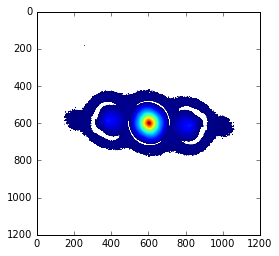

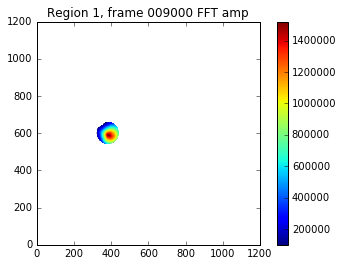

000
100121.36471204313
1520652.6886624661
724552.1651079609
724552.1651079609
000
{'med_lowFreqPerfect': 4608590.448339828, 'normVec_lowFreqPerfect': array([ 8.21353296e-09, -7.89805199e-09,  4.96904301e+06]), 'med_rect': 261729.3228451443, 'med_highFreqPerfect_R': 724552.1651079609, 'normVec_highFreqPerfect_L': array([   7118.55803887,   -5658.89667275, 1409849.45818225]), 'normVec_highFreqPerfect_R': array([  -7118.55803887,    5658.89667274, 3161443.09753563]), 'normVec_rect': array([ 6.17674800e-11, -7.38964445e-11,  8.32056694e+05]), 'med_highFreqPerfect_L': 724552.1651079609}


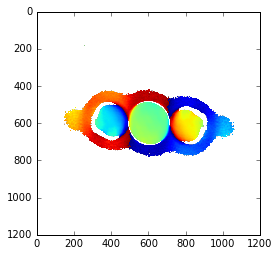

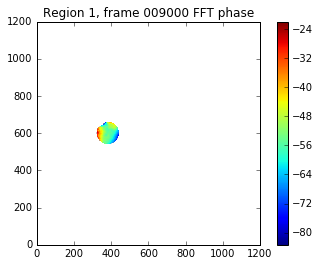

000
-83.34692428953137
-21.96891864611682
-53.74697525783541
-53.74697525783541
000
{'med_lowFreqPerfect': 0.0, 'normVec_lowFreqPerfect': array([ -0.14466484,   0.16276944, -10.86276359]), 'med_rect': 0.0, 'med_highFreqPerfect_R': 53.74697525783541, 'normVec_highFreqPerfect_L': array([-0.22388664,  0.06501547, -6.8475689 ]), 'normVec_highFreqPerfect_R': array([-2.23886636e-01,  6.50154682e-02,  1.97492971e+02]), 'normVec_rect': array([-1.92431599e-01,  6.70924112e-04,  1.15056405e+02]), 'med_highFreqPerfect_L': -53.74697525783541}
2.77790689468
-----
Working on frame 009001 ...


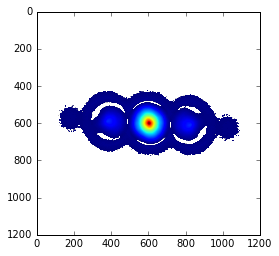

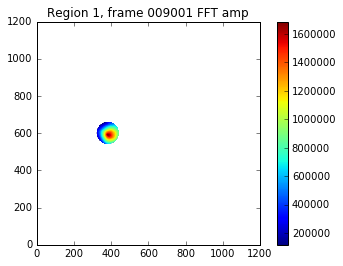

000
119649.66431827117
1687060.015636596
816834.3627132376
816834.3627132376
000
{'med_lowFreqPerfect': 4605442.720692768, 'normVec_lowFreqPerfect': array([ 8.20557489e-09, -7.80710252e-09,  4.96435003e+06]), 'med_rect': 230046.5055199042, 'med_highFreqPerfect_R': 816834.3627132376, 'normVec_highFreqPerfect_L': array([  6977.24824443,  -4405.44810612, 815575.42833667]), 'normVec_highFreqPerfect_R': array([  -6977.24824442,    4405.44810612, 3901735.59429884]), 'normVec_rect': array([ 5.09672304e-11, -5.47970558e-11,  8.20929950e+05]), 'med_highFreqPerfect_L': 816834.3627132376}


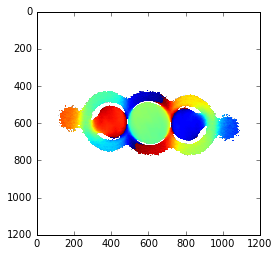

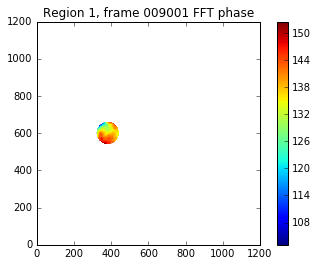

000
103.07636929226364
152.53065577577442
137.93574468683386
137.93574468683386
000
{'med_lowFreqPerfect': 0.0, 'normVec_lowFreqPerfect': array([-8.40184220e-02, -1.11589587e-01,  1.17364805e+02]), 'med_rect': 0.0, 'med_highFreqPerfect_R': -137.93574468683386, 'normVec_highFreqPerfect_L': array([ 3.53220097e-02, -1.57260033e-01,  2.18320372e+02]), 'normVec_highFreqPerfect_R': array([ 3.53220097e-02, -1.57260033e-01, -7.19947439e+01]), 'normVec_rect': array([-1.23360788e-01, -1.18852741e-01,  1.45328117e+02]), 'med_highFreqPerfect_L': 137.93574468683386}
2.84740304947
-----


In [194]:
# for loop over science images to take FFT and analyze it

ampArray = []
framenumArray = []

counter_num = 0

for f in range(9000,9002):  # full Altair dataset: 4249,11497

    start = time.time() # start timer
    
    filename_str = stem+'lm_180507_'+str("{:0>6d}".format(f))+'_nPCA164.fits'
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
            
        print('Working on frame '+str("{:0>6d}".format(f))+' ...')
        
        image, header = fits.getdata(filename_str,0,header=True) 
        
        # test: a perfect PSF
        #image, header = fits.getdata('perfect_psf.fits',0,header=True) 
    
        #plt.imshow(image)
        #plt.show()
    
        # locate PSF
        psf_loc = overlap_psfs.find_airy_psf(image)
    
        # size of cookie cut-out (measured center-to-edge)
        cookie_size = 100 # maximum control radius as of 2018 July corresponds to 130.0 pixels
    
        # take FFT
        cookie_cut = image[psf_loc[0]-cookie_size:psf_loc[0]+cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        amp, arg = fft_img(cookie_cut).fft(padding=int(5*cookie_size), mask_thresh=1e5)

        # sanity check (and to avoid getting for loop stuck)
        if (np.shape(amp)[0]!=np.shape(amp)[1]): # if the FFT doesn't make sense (i.e., if PSF was not found)
            print('PSF does not make sense ... aborting this one ...')
            continue
            
        #print(np.shape(amp))

        # analyze FFTs
        fftInfo_amp = fftMask(amp,wavel_lambda,plateScale,
                              fyi_string=str("{:0>6d}".format(f))+' FFT amp')
        fftInfo_arg = fftMask(arg,wavel_lambda,plateScale,
                              fyi_string=str("{:0>6d}".format(f))+' FFT phase')
        
        ## ## INCLUDE BIT TO WRITE '--' IN CSV AS NANS
        
        # append to file:
        # [0]: frame number
        # [1-12]: FFT amplitude data
        # [13-24]: FFT phase data
        fields=[str("{:0>6d}".format(f)),
                fftInfo_amp["med_highFreqPerfect_L"],
                fftInfo_amp["med_highFreqPerfect_R"],
                fftInfo_amp["med_lowFreqPerfect"],
                fftInfo_amp["med_rect"],
                fftInfo_amp["normVec_highFreqPerfect_L"][0],
                fftInfo_amp["normVec_highFreqPerfect_L"][1],
                fftInfo_amp["normVec_highFreqPerfect_R"][0],
                fftInfo_amp["normVec_highFreqPerfect_R"][1],
                fftInfo_amp["normVec_lowFreqPerfect"][0],
                fftInfo_amp["normVec_lowFreqPerfect"][1],
                fftInfo_amp["normVec_rect"][0],
                fftInfo_amp["normVec_rect"][1],
                fftInfo_arg["med_highFreqPerfect_L"],
                fftInfo_arg["med_highFreqPerfect_R"],
                fftInfo_arg["med_lowFreqPerfect"],
                fftInfo_arg["med_rect"],
                fftInfo_arg["normVec_highFreqPerfect_L"][0],
                fftInfo_arg["normVec_highFreqPerfect_L"][1],
                fftInfo_arg["normVec_highFreqPerfect_R"][0],
                fftInfo_arg["normVec_highFreqPerfect_R"][1],
                fftInfo_arg["normVec_lowFreqPerfect"][0],
                fftInfo_arg["normVec_lowFreqPerfect"][1],
                fftInfo_arg["normVec_rect"][0],
                fftInfo_arg["normVec_rect"][1]]
        with open(r'test.csv', 'a') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(fields)
            
    else: # if file does not exist
        print('Frame '+str("{:0>6d}".format(f))+' not found.')
            
    end = time.time()
    print(end - start)
    print('-----')

        #plt.show()

In [13]:
import pandas as pd
df = pd.read_csv("test.csv")

In [15]:
df.keys()

Index([u'framenum', u'ampl_med_highFreqPerfect_L',
       u'ampl_med_highFreqPerfect_R', u'ampl_med_lowFreqPerfect',
       u'ampl_med_rect', u'ampl_normVec_highFreqPerfect_L_ax',
       u'ampl_normVec_highFreqPerfect_L_by',
       u'ampl_normVec_highFreqPerfect_R_ax',
       u'ampl_normVec_highFreqPerfect_R_by', u'ampl_normVec_lowFreqPerfect_ax',
       u'ampl_normVec_lowFreqPerfect_by', u'ampl_normVec_rect_ax',
       u'ampl_normVec_rect_by', u'phase_med_highFreqPerfect_L',
       u'phase_med_highFreqPerfect_R', u'phase_med_lowFreqPerfect',
       u'phase_med_rect', u'phase_normVec_highFreqPerfect_L_ax',
       u'phase_normVec_highFreqPerfect_L_by',
       u'phase_normVec_highFreqPerfect_R_ax',
       u'phase_normVec_highFreqPerfect_R_by',
       u'phase_normVec_lowFreqPerfect_ax', u'phase_normVec_lowFreqPerfect_by',
       u'phase_normVec_rect_ax', u'phase_normVec_rect_by'],
      dtype='object')

In [24]:
df["ampl_med_highFreqPerfect_L"]

0    NaN
1     --
2    NaN
3     --
4    NaN
5    NaN
6    NaN
7     --
8    NaN
9    NaN
Name: ampl_med_highFreqPerfect_L, dtype: object

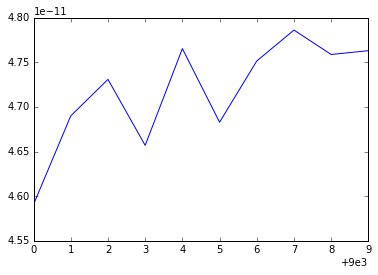

In [23]:
plt.plot(df["framenum"],df["ampl_normVec_rect_ax"])
plt.show()

In [ ]:
# read in PSF analysis file and make plots

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
psf_analysis = pd.read_csv("psf_analysis_altair_data.csv", na_values="--")

In [36]:
[print(i) for i in psf_analysis.keys()]

framenum
amp_med_highFreqPerfect_L
amp_med_highFreqPerfect_R
amp_med_lowFreqPerfect
amp_med_rect
amp_normVec_highFreqPerfect_L_x
amp_normVec_highFreqPerfect_L_y
amp_normVec_highFreqPerfect_R_x
amp_normVec_highFreqPerfect_R_y
amp_normVec_lowFreqPerfect_x
amp_normVec_lowFreqPerfect_y
amp_normVec_rect_x
amp_normVec_rect_y
arg_med_highFreqPerfect_L
arg_med_highFreqPerfect_R
arg_med_lowFreqPerfect
arg_med_rect
arg_normVec_highFreqPerfect_L_x
arg_normVec_highFreqPerfect_L_y
arg_normVec_highFreqPerfect_R_x
arg_normVec_highFreqPerfect_R_y
arg_normVec_lowFreqPerfect_x
arg_normVec_lowFreqPerfect_y
arg_normVec_rect_x
arg_normVec_rect_y


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

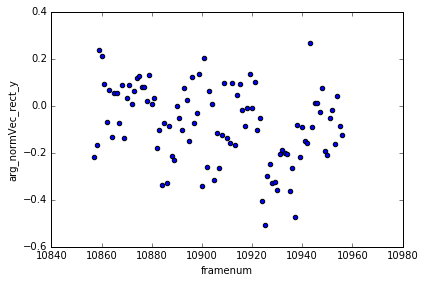

In [46]:
x_axis = "framenum"
y_axis = "arg_normVec_rect_y"
plt.scatter(psf_analysis[x_axis][6500:6600],psf_analysis[y_axis][6500:6600])
plt.xlabel(x_axis)
plt.ylabel(y_axis)
#plt.ylim([-0.00005,0.00005])
plt.tight_layout()
plt.savefig(y_axis+"_vs_"+x_axis+"_testDetail.pdf")
#plt.show()

In [ ]:
# how are FFTs affected by
# 1. fringe movement
# 2. changing visibility
# 3. stuff listed in my table

# ... and how good am I at finding the center of the PSF?

In [ ]:
# based on the images, decide whether to move HPC in piston, tip, tilt
# iterate?
# maybe I don't want to move HPC in piston, because I found the center of the envelope with the grism,
# and Phasecam isn't closed yet